<a href="https://colab.research.google.com/github/mmehdig/apl-esslli-19-material/blob/master/2-language-models-part2/encoder-decoder_image_description.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Description In Encoder-Decoder Frameworks

In this tutorial, you get familar with application of pretrained convolutional neural networks (ConvNets) for visual understanding.

In [0]:
%matplotlib inline

## library
# GPU selection (if needed)
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np
from matplotlib import pyplot as plt

from glob import glob

## Object Recognition With ConvNets

Object recogntion is one of the basic tasks in visual understanding. With a limited list of objects it simply becomes a classification task. For example, ILSVRC-2013 (ImageNet) provides largest dataset of pictures in 1000 categories of object names in English language.
The state of the art models in this task are based on some variations of Convolutional Neural Networks.

Here is an example of how such model can be used for object classification.


In [0]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

# The model here: https://arxiv.org/abs/1512.03385
# Pre-trained on ImageNet object recogntion:
obj_recognition_model = ResNet50(weights='imagenet')

In [0]:
# download few sample images
! wget -q https://gubox.box.com/shared/static/ois9pg8t2j65ir8lhcapo7e3yctzwj27.jpg 
! wget -q https://gubox.box.com/shared/static/7yo0mhiz8wi81ysfbgjns6f2cgsc80yk.jpg 
! wget -q https://gubox.box.com/shared/static/8yzk194f3flmctzqe344fq39deyhanl6.jpg 
! wget -q https://gubox.box.com/shared/static/vpg4gc5k1xocp0r9y5tyfjqtphr7ntj2.jpg 
! mkdir sample_images
! mv 7yo0mhiz8wi81ysfbgjns6f2cgsc80yk.jpg sample_images/volleyball.jpg
! mv vpg4gc5k1xocp0r9y5tyfjqtphr7ntj2.jpg sample_images/shovel.jpg
! mv 8yzk194f3flmctzqe344fq39deyhanl6.jpg sample_images/bicycle.jpg
! mv ois9pg8t2j65ir8lhcapo7e3yctzwj27.jpg sample_images/potter.jpg
# similarly you can download any image in sample_images directory.

In [0]:
# read images
# represent them in numpy array
# preprocessed images for object recognition

img_paths = [
    path
    for path in glob('sample_images/*.jpg')
]

imgs = np.array([
    image.img_to_array(image.load_img(img_path, target_size=(224, 224)))
    for img_path in img_paths
])

x = preprocess_input(imgs)

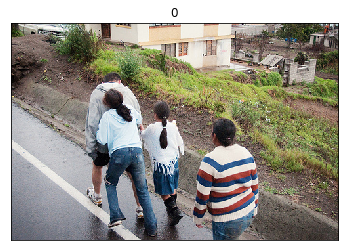

0.246 picket_fence
0.154 crutch
0.068 mailbox
0.037 worm_fence
0.029 castle


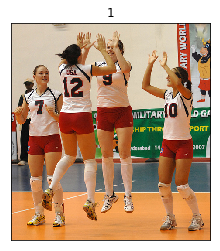

0.926 volleyball
0.028 knee_pad
0.018 basketball
0.009 soccer_ball
0.006 miniskirt


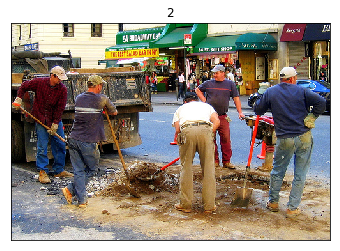

0.268 shovel
0.196 swab
0.154 chain_saw
0.067 broom
0.043 jinrikisha


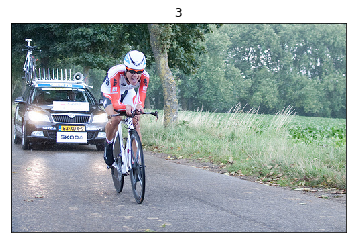

0.951 jinrikisha
0.035 bicycle-built-for-two
0.003 tricycle
0.002 horse_cart
0.002 moped


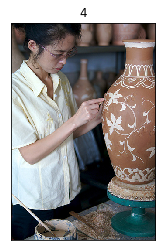

0.905 potter's_wheel
0.055 water_jug
0.026 vase
0.004 milk_can
0.003 pitcher


In [17]:
y_preds = obj_recognition_model.predict(x)
preds = decode_predictions(y_preds)

for i, (img_path, pred) in enumerate(zip(img_paths, preds)):
  print('====' * 10)
  plt.imshow(plt.imread(img_path))
  plt.xticks([])
  plt.yticks([])
  plt.title(i)
  plt.show()
  for _, obj_name, obj_prob in pred[:5]:  
    print(f"{obj_prob:.3f} {obj_name}")
  print('====' * 10)


## Visual Feature Extraction With Pre-trained ConvNets

The outputs of intermediate layers in ConvNets can be used as basic representation of the image for many other tasks. 

In [19]:
# By excluding the top-layer, the output of the model for each image is a tensor of (7 x 7 x 2048)
# The 7 x 7 dimensions corresponds to 7 x 7 regions in the picture. 
# In other words, each region is represented with a 2048-dimension vector.
convnet_model = ResNet50(weights='imagenet', input_shape=[224, 224, 3],  include_top=False)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 3s 0us/step


In [0]:
visual_features = convnet_model.predict(x)

In [27]:
print("The model's output shape:", visual_features.shape)
# number of images, 
# 7 x 7 regions
# feature vector per region.

The model's output shape: (5, 7, 7, 2048)


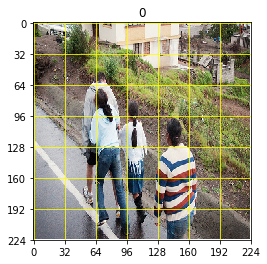

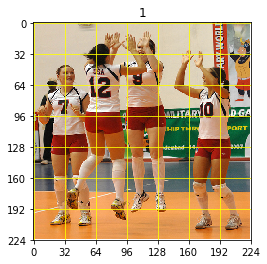

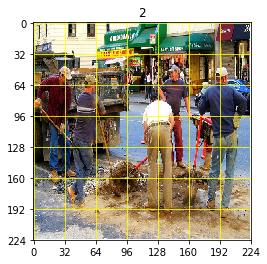

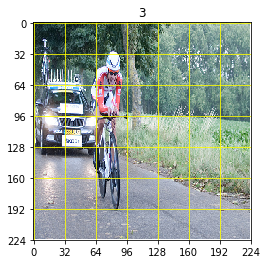

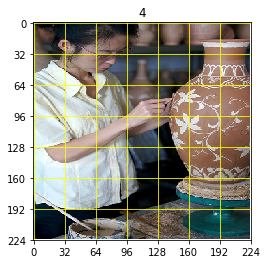

In [25]:
# The feature vector in each 7x7 regions roughly represents each grid-cell.
for i, img_path in enumerate(img_paths):
    img = image.load_img(img_path, target_size=(224, 224))
    plt.imshow(img)
    plt.xticks(range(0, 225, 32))
    plt.yticks(range(0, 225, 32))
    plt.title(i)
    plt.grid(True, color='yellow')
    plt.show()

## Decode With Conditional Language Model

We trained a simple condigional language model on Flickr30K corpus, conditioned with visual features from pre-trained ResNet50 model.

In [30]:
# download the caption model
! wget https://gubox.box.com/shared/static/3ragfmnc3p7fi3v6u5yia57wttiqbazz.h5
! mv 3ragfmnc3p7fi3v6u5yia57wttiqbazz.h5 simple_caption_model.h5

--2019-08-14 23:24:24--  https://gubox.box.com/shared/static/3ragfmnc3p7fi3v6u5yia57wttiqbazz.h5
Resolving gubox.box.com (gubox.box.com)... 107.152.24.197
Connecting to gubox.box.com (gubox.box.com)|107.152.24.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/3ragfmnc3p7fi3v6u5yia57wttiqbazz.h5 [following]
--2019-08-14 23:24:24--  https://gubox.box.com/public/static/3ragfmnc3p7fi3v6u5yia57wttiqbazz.h5
Reusing existing connection to gubox.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://gubox.app.box.com/public/static/3ragfmnc3p7fi3v6u5yia57wttiqbazz.h5 [following]
--2019-08-14 23:24:24--  https://gubox.app.box.com/public/static/3ragfmnc3p7fi3v6u5yia57wttiqbazz.h5
Resolving gubox.app.box.com (gubox.app.box.com)... 107.152.24.199, 107.152.25.199
Connecting to gubox.app.box.com (gubox.app.box.com)|107.152.24.199|:443... connected.
HTTP request sent, awaiting response... 302 Found
Locati

In [31]:
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K

caption_model = load_model("simple_caption_model.h5")

W0814 23:24:31.737624 140092485609344 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0814 23:24:31.740000 140092485609344 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0814 23:24:31.750452 140092485609344 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with d

In [32]:
# download language coding info about the decoder
! mkdir preprocessed_flickr30k
! wget https://gubox.box.com/shared/static/7ykwlf5wbi86fw0nzmz7pnrizv6lw6j2.npy
! mv 7ykwlf5wbi86fw0nzmz7pnrizv6lw6j2.npy preprocessed_flickr30k/ix2word.npy

--2019-08-14 23:25:02--  https://gubox.box.com/shared/static/7ykwlf5wbi86fw0nzmz7pnrizv6lw6j2.npy
Resolving gubox.box.com (gubox.box.com)... 107.152.24.197
Connecting to gubox.box.com (gubox.box.com)|107.152.24.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/7ykwlf5wbi86fw0nzmz7pnrizv6lw6j2.npy [following]
--2019-08-14 23:25:02--  https://gubox.box.com/public/static/7ykwlf5wbi86fw0nzmz7pnrizv6lw6j2.npy
Reusing existing connection to gubox.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://gubox.app.box.com/public/static/7ykwlf5wbi86fw0nzmz7pnrizv6lw6j2.npy [following]
--2019-08-14 23:25:02--  https://gubox.app.box.com/public/static/7ykwlf5wbi86fw0nzmz7pnrizv6lw6j2.npy
Resolving gubox.app.box.com (gubox.app.box.com)... 107.152.24.199, 107.152.25.199
Connecting to gubox.app.box.com (gubox.app.box.com)|107.152.24.199|:443... connected.
HTTP request sent, awaiting response... 302 Found
L

In [0]:
max_len = 25
ix2word = np.load('preprocessed_flickr30k/ix2word.npy', allow_pickle=True)[None][0]
word2ix = {w: ix for ix, w in ix2word.items()}

def sent2ixs(sent):
    return [word2ix['<s>']]+[word2ix[w] for w in sent]+[word2ix['</s>']]+[word2ix['<pad/>']]*(max_len-len(sent))

def ixs2sent(ixs):
    return [ix2word[ix] for ix in ixs if ix2word[ix] != '<pad/>']

## How It works?

#### Likelihood Of Descriptions

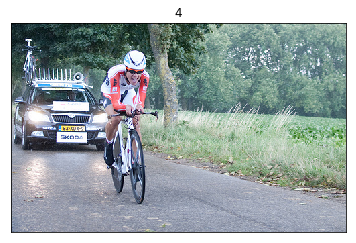

In [34]:
# choose an image here
image_index = 3
plt.imshow(plt.imread(img_paths[image_index]))
plt.xticks([])
plt.yticks([])
plt.title(i)
plt.show()


In [0]:
# propose a few sentences which describes the image:
sents = np.array([
    sent2ixs("a group of men are standing .".split(" ")),
    sent2ixs("a group of men are working .".split(" ")),
    sent2ixs("a group of men with hat are working .".split(" ")),
    sent2ixs("a group of men with cat are working .".split(" ")),
    sent2ixs("people are celebrating on street .".split(" ")),
])


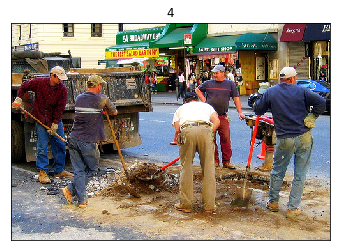

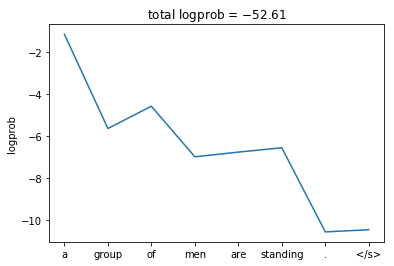

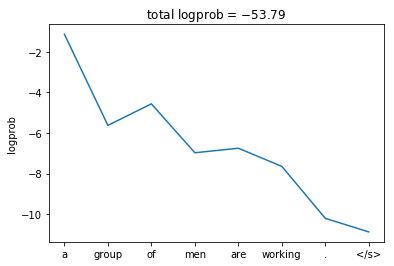

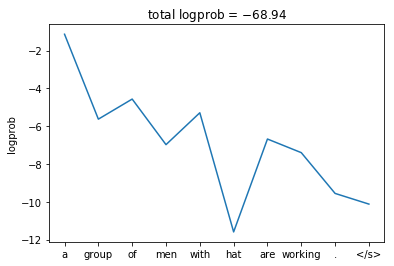

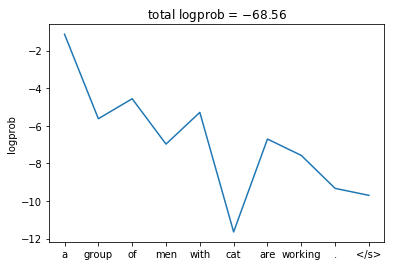

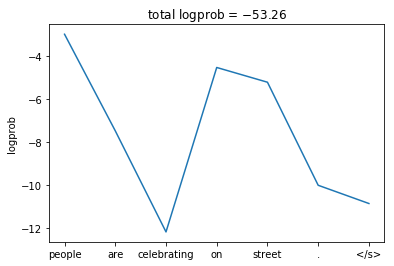

In [0]:
# repeat the image for all test sentences:
vfs = np.array([visual_features[image_index]] * len(sents))

# predict the token probabilities with the given sentnece and the visual features:
sents_prs = caption_model.predict([sents[:, :-1], vfs])
for sent, prs in zip(sents[:, 1:], sents_prs):
    words_prs = [
        (ix2word[ixw], pr[ixw])
        for pr, ixw in zip(prs, sent)
        if ix2word[ixw] not in {'<pad/>'}
    ]
    
    words, prs = zip(*words_prs)
    
    logprobs = np.log(prs)
    plt.title("total logprob = ${0:.2f}$".format(logprobs.sum()))
    plt.plot(logprobs)
    plt.xticks(range(len(words)), words)
    plt.ylabel("logprob")
    plt.show()
    

#### Beam Search for caption generation

In [0]:
# This implementation only accepts one source image as source input.
def search(model, src_input, k=1, sequence_max_len=25):
    # (log(1), initialize_of_zeros)
    k_beam = [(0, [word2ix['<s>'],word2ix['</s>']]+[word2ix['<pad/>']]*(sequence_max_len-1))]

    # l : point on target sentence to predict
    for l in range(sequence_max_len):
        all_k_beams = []
        for prob, sent_predict in k_beam:
            predicted = model.predict([np.array([sent_predict]), np.array([src_input])])[0]
            # top k!
            possible_k = predicted[l].argsort()[-k:][::-1]

            # add to all possible candidates for k-beams
            all_k_beams += [
                (
                    sum(np.log(predicted[i][sent_predict[i+1]]) for i in range(l)) + np.log(predicted[l][next_wid]),
                    list(sent_predict[:l+1])+[next_wid]+[0]*(sequence_max_len-l-1)
                )
                for next_wid in possible_k
            ]

        # top k
        k_beam = sorted(all_k_beams)[-k:][::-1]

    return k_beam

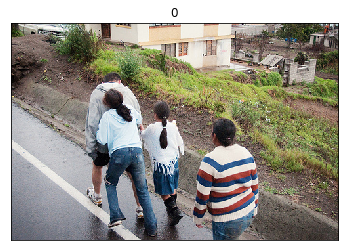

Top 5 beams:
logprob=-25.41 sent=a man is a man is a man is a man is a man is a man is a man is a man is
logprob=-26.45 sent=a man is a dog is a man is a man is a man is a man is a man is a man is
logprob=-26.50 sent=a man is a man is a man is a man is a man is a man is a man is a dog is
logprob=-26.79 sent=a man is a man is a man is a man is a man is a man is a man is a man is
logprob=-26.79 sent=a man is a a man is a man is a man is a man is a man is a man is a man


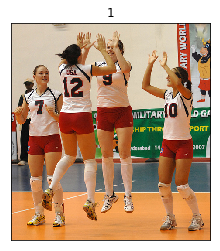

Top 5 beams:
logprob=-41.75 sent=a basketball two basketball two basketball two basketball two basketball two basketball two basketball two basketball two basketball two basketball two basketball two basketball
logprob=-42.00 sent=a basketball two basketball two basketball two basketball two basketball two basketball two basketball two basketball two basketball two basketball two basketball two two
logprob=-42.11 sent=a basketball two basketball two basketball two basketball two basketball two basketball two basketball two basketball two two basketball two basketball two basketball two
logprob=-42.18 sent=a basketball two basketball two basketball two basketball two basketball two basketball two two basketball two basketball two basketball two basketball two basketball two
logprob=-42.27 sent=a basketball two basketball two basketball two two basketball two basketball two basketball two basketball two basketball two basketball two basketball two basketball two


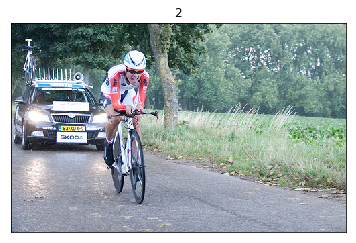

Top 5 beams:
logprob=-16.95 sent=a a a a a a a a a a a a a a a a a a a a a a a a
logprob=-18.09 sent=a a a a a a a a a a a a a a a a a a a a a a a a
logprob=-18.71 sent=a a a a a a a a a a a a a a a a a a a a a a man is
logprob=-18.91 sent=a man is a a a a a a a a a a a a a a a a a a a a a
logprob=-18.94 sent=a man a a a a a a a a a a a a a a a a a a a a a a


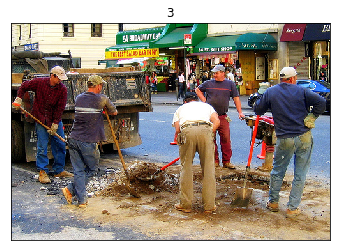

Top 5 beams:
logprob=-37.15 sent=a three a children a front a front a front a front a front a front a front a front a front a front
logprob=-37.35 sent=a three a children a front a front a front a front a front a front a front a front a front front front
logprob=-37.54 sent=a three a children a front a front a front a front a front a front a front a front a front a front
logprob=-37.58 sent=a three a children a front a front a front a front a front a front a front a front a front front a
logprob=-37.61 sent=a three a children a front a front a front a front a front a front a front a front a front front front


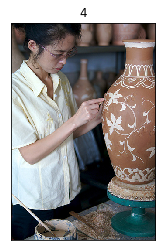

Top 5 beams:
logprob=-26.46 sent=a woman sitting in a woman in a woman in a woman in a woman in a woman in a woman in a woman
logprob=-26.50 sent=a woman in a woman in a woman in a woman in a woman in a woman in a woman in a woman in
logprob=-27.21 sent=a woman in a woman in a girl in a woman in a woman in a woman in a woman in a woman in
logprob=-27.23 sent=a woman in a girl in a woman in a woman in a woman in a woman in a woman in a woman in
logprob=-27.31 sent=a woman in a woman in a woman in a girl in a woman in a woman in a woman in a woman in


In [0]:
k = 5
for i, vf in enumerate(visual_features):
    plt.imshow(plt.imread(img_paths[i]))
    plt.xticks([])
    plt.yticks([])
    plt.title(i)
    plt.show()
    print("Top {0} beams:".format(k))
    top_k = search(caption_model, vf, k=k)
    for logprob, ixs in top_k:
        print("logprob={0:.2f} sent={1}".format(logprob, " ".join(ixs2sent(ixs)[1:-1])))



```
@article{flickrentitiesijcv,
         author={Bryan A. Plummer and Liwei Wang and Christopher M. Cervantes and Juan C. Caicedo and Julia Hockenmaier and Svetlana Lazebnik},
         title={Flickr30K Entities: Collecting Region-to-Phrase Correspondences for Richer Image-to-Sentence Models},
         journal={IJCV},
         volume={123},
         number={1},
         pages={74-93},
         year={2017} 
}
```

